# Aprendizaje supervisado: Máquinas de Vector Soporte (_Support Vector Machines_)

Durante este cuadernillo, veremos las SVM (máquinas de vector soporte). Estos modelos pertenecen a la familia del aprendizaje supervisado.

## Introducción teórica

Una SVM trabaja, como los modelos de KNN, con dimensiones y distancias. Sin embargo, a diferencia de los KNN, no busca situar en el espacio cada uno de los puntos, sino en crear una división espacial en la que los puntos se situan. Conceptualmente, son estrategias muy distintas y deben afrontarse de distintas formas.

Pueden existir infinitas situaciones en las que los puntos no sean divisibles en las dimensiones en las que están representados, por ello, las SVM pueden crear dimensiones adicionales buscando aquella en la que sea más sencillo separar los datos.

Como posiblemente hayas podido intuir, como las SVM son capaces de crear nuevas dimensiones, se suelen utilizar en problemas donde la **dimensionalidad** es un gran problema. Estos modelos pueden trabajar, incluso, en problemas en los que hay más dimensiones que instancias (imagínate lo extremo que es este caso: 10 filas y 80 columnas; SVM funcionará). La gran desventaja es que la elección de sus hiperparámetros (el entrenamiento, en general) es extremadamente lento en comparación con otras estrategias.

Veamos un ejemplo.

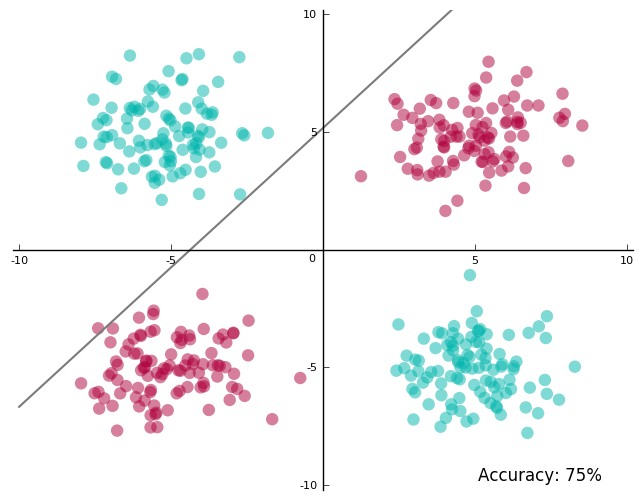

Imagen 1. Ejemplo de problema **NO** divisible en dos dimensiones.

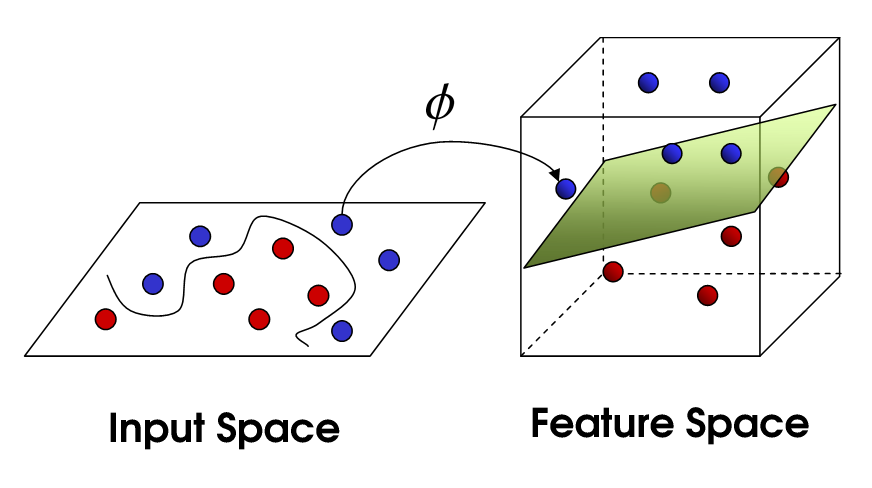

Imagen 2. Aumento de la dimensionalidad.

Hay datos que no son divisibles en _n_ dimensiones. Para solucionar este problema y establecer una frontera correcta, las SVM crean _m_ nuevas dimensiones que permiten alejar los datos entre sí y buscan el _n+m-1_-hiperplano que divide el conjunto de datos por clases.

## Conjunto de datos y limpieza

Vamos a trabajar con el _dataset_ geyser.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.datasets import load_digits

Voy a cargarlo y a transformarlo en un _dataframe_, que es la forma en la que estamos acostumbrados a trabajar (podría trabajar directamente con lo que tengo).

In [ ]:
data = load_digits()
_df = pd.DataFrame(data["data"], columns=data["feature_names"])
target = pd.DataFrame(data["target"], columns=["number"])
df = pd.concat([_df, target], axis = 1)
df.head()

,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,pixel_1_1,...,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7,number
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0,1
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0,2
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0,3
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0,4


Como puedes ver, tenemos un conjunto de datos con **65** _features_ (_oh, sorpresa, es lo que pasa cuando aplanas una imagen_).

Este _dataset_ contiene la información en escala de grises (del 0 al 255) para cada píxel en una imagen de 8x8 (_ya ves qué calidad_). De hecho, podemos representarlo de esa forma para que te lo creas.

In [ ]:
example = np.array(df.loc[0, :])[:-1] # el primer dato
number = df.loc[0, "number"] # la primera etiqueta

Como tengo la imagen aplanada, voy a reestructurarla de nuevo a dos dimensiones usando la función _reshape_. Esta función ya la usamos en el tema anterior para pasar a nuestros ```SimpleImputer``` una columna de filas.

In [ ]:
example_2d = example.reshape((8, 8))
example_2d

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

¿Puedes imaginarte qué numero es? Vamos a mostrarlo por pantalla.

np.int64(0)

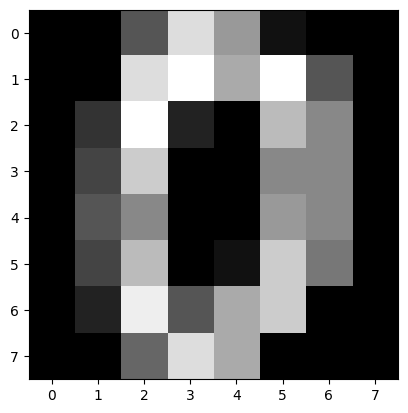

In [ ]:
plt.imshow(example_2d, cmap="gray"); number # también muestro su etiqueta para ver si lo estoy haciendo bien

Separemos ahora este conjunto de datos.

### Separación del conjunto de datos

Como voy a usar una SVM, voy a trabajar con un ```train_test_split```. Si trabajase con _folds_, este cuadernillo podría tardar horas en ejecutarse.

In [ ]:
from sklearn.model_selection import train_test_split

random_seed = 33

In [ ]:
train_val, test = train_test_split(df, test_size=0.2, random_state=random_seed)
train, val = train_test_split(train_val, test_size=0.15, random_state=random_seed)

### Columnas inútiles, valores sin sentido y atípicos

No tenemos ninguna columna inútil. Todas las que tenemos, de hecho, nos sirven para representar nuestra imagen.

In [ ]:
train.describe()

,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,pixel_1_1,...,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7,number
count,1221.0,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,...,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000
mean,0.0,0.305487,5.159705,11.819820,11.828010,5.809992,1.407043,0.128583,0.004914,1.972973,...,0.206388,0.000819,0.276822,5.493857,12.028665,11.731368,6.617527,2.051597,0.371826,4.552826
std,0.0,0.936095,4.733717,4.244221,4.308767,5.668428,3.388348,1.035759,0.080828,3.173159,...,0.988454,0.028618,0.948871,5.093648,4.367165,5.007035,5.936852,4.108543,1.897624,2.876964
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.000000,1.000000,10.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,10.000000,10.000000,0.000000,0.000000,0.000000,2.000000
50%,0.0,0.000000,4.000000,13.000000,13.000000,4.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,4.000000,13.000000,14.000000,6.000000,0.000000,0.000000,5.000000
75%,0.0,0.000000,9.000000,15.000000,15.000000,11.000000,0.000000,0.000000,0.000000,3.000000,...,0.000000,0.000000,0.000000,9.000000,16.000000,16.000000,12.000000,2.000000,0.000000,7.000000
max,0.0,8.000000,16.000000,16.000000,16.000000,16.000000,16.000000,15.000000,2.000000,14.000000,...,10.000000,1.000000,9.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,9.000000


Evidentemente, no podemos trabajar de forma visual (tenemos demasiadas columnas). Vamos a tener que hacerlo de forma programática.

Quiero ver si tengo algún valor máximo por encima de 255 o algún mínimo por debajo de 0.

Para ello, usaré máscaras booleanas, de esta forma:

In [ ]:
df < 0

,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,pixel_1_1,...,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7,number
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1792,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1793,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1794,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1795,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
(train < 0).any().any() # un any por cada dimensión

np.False_

In [ ]:
(train > 255).any().any()

np.False_

¿Tengo alguna etiqueta distinta de los dígitos 0-9?

In [ ]:
train[(train.number < 0) | (train.number > 9)] # no, no tengo

,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,pixel_1_1,...,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7,number


No tengo valores sin sentido.

En este ejemplo, no voy a borrar los datos atípicos. Cada persona puede realizar un dígito de formas muy distintas entre sí, por lo que la existencia de valores atípicos puede explicar zonas del espacio que no estén bien explicadas.

### Tratamiento de valores nulos

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1221 entries, 313 to 1222
Data columns (total 65 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pixel_0_0  1221 non-null   float64
 1   pixel_0_1  1221 non-null   float64
 2   pixel_0_2  1221 non-null   float64
 3   pixel_0_3  1221 non-null   float64
 4   pixel_0_4  1221 non-null   float64
 5   pixel_0_5  1221 non-null   float64
 6   pixel_0_6  1221 non-null   float64
 7   pixel_0_7  1221 non-null   float64
 8   pixel_1_0  1221 non-null   float64
 9   pixel_1_1  1221 non-null   float64
 10  pixel_1_2  1221 non-null   float64
 11  pixel_1_3  1221 non-null   float64
 12  pixel_1_4  1221 non-null   float64
 13  pixel_1_5  1221 non-null   float64
 14  pixel_1_6  1221 non-null   float64
 15  pixel_1_7  1221 non-null   float64
 16  pixel_2_0  1221 non-null   float64
 17  pixel_2_1  1221 non-null   float64
 18  pixel_2_2  1221 non-null   float64
 19  pixel_2_3  1221 non-null   float64
 20  pixel_2_4  

No tengo ninguno.

### Análisis de variabilidad, columnas categóricas y correlación

No tengo columnas categóricas (bueno, la variable objetivo es categórica, pero no la tocamos nunca). Por otra parte, como tengo tantas dimensiones, no va a modificar enormemente el resultado eliminar algunas de ellas (lo vamos a comprobar por si acaso), así que **prefiero quedarme con todas** (decisión arbitraria, posiblemente obtendría mejores resultados si las elimino).

In [ ]:
train.corr() # fíjate cómo no hay casi ningún valor por encima de 0.8 o debajo de -0.8

,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,pixel_1_1,...,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7,number
pixel_0_0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pixel_0_1,NaN,1.000000,0.552791,0.210274,-0.011146,0.072893,0.056898,-0.036320,0.001810,0.570133,...,-0.043392,-0.009347,0.865363,0.548517,0.133196,-0.111189,-0.036037,0.025096,-0.038618,-0.047542
pixel_0_2,NaN,0.552791,1.000000,0.565916,-0.085898,0.038583,0.007544,-0.058525,0.015085,0.594380,...,0.019227,-0.031219,0.507681,0.934805,0.477992,-0.151908,-0.033408,0.100093,0.090746,0.000794
pixel_0_3,NaN,0.210274,0.565916,1.000000,0.010316,-0.178353,-0.121658,-0.036679,0.026477,0.325131,...,0.067291,-0.059520,0.173797,0.563331,0.756925,-0.083626,-0.042326,0.070526,0.074478,0.003130
pixel_0_4,NaN,-0.011146,-0.085898,0.010316,1.000000,0.495956,0.129269,0.030856,0.037732,0.029515,...,-0.246662,0.021085,-0.037865,-0.022643,-0.009669,-0.088464,-0.241197,-0.274763,-0.244998,0.121011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pixel_7_4,NaN,-0.111189,-0.151908,-0.083626,-0.088464,-0.367565,-0.383587,-0.167666,0.049847,-0.003604,...,0.114887,0.007257,-0.135985,-0.231722,0.066739,1.000000,0.607117,0.264965,0.123187,-0.195780
pixel_7_5,NaN,-0.036037,-0.033408,-0.042326,-0.241197,-0.296587,-0.311385,-0.137158,0.015877,0.075550,...,0.277873,-0.002979,-0.055543,-0.087587,-0.072037,0.607117,1.000000,0.656028,0.279288,-0.086758
pixel_7_6,NaN,0.025096,0.100093,0.070526,-0.274763,-0.286459,-0.180150,-0.062042,-0.003232,0.139684,...,0.532238,-0.014302,0.011261,0.065092,0.046468,0.264965,0.656028,1.000000,0.632335,-0.125989
pixel_7_7,NaN,-0.038618,0.090746,0.074478,-0.244998,-0.175626,-0.081434,-0.024345,-0.011922,0.001943,...,0.569532,-0.005612,-0.044010,0.044503,0.108500,0.123187,0.279288,0.632335,1.000000,-0.191726


### Estandarización de los datos

Como los datos representan imágenes en escalas de grises (0 - 255), vamos a estandarizar los datos.

Primero, separamos nuestros conjuntos en datos + etiquetas.

In [ ]:
X_train, y_train = train.drop(columns="number"), train.number
X_val, y_val = val.drop(columns="number"), val.number

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
ss = StandardScaler().fit(X_train)
X_train_std = ss.transform(X_train)
X_val_std = ss.transform(X_val)

Ahora, veamos cómo de bueno es nuestro modelo SVM. Como es un problema de clasificación, usaremos las métricas de **precisión** y **recall**, fusionándolas con la média harmónica.

In [ ]:
from sklearn.svm import SVC # C de classifier

from sklearn.metrics import precision_score, recall_score

In [ ]:
def harmonic_mean(numbers):
    # calculo la suma de los inversos
    inverse_sum = sum([1 / number for number in numbers])
    return len(numbers) / inverse_sum

def evaluate_model(X_train, y_train, X_test, y_test, model, log: bool = True):
  model = model.fit(X_train, y_train)

  # train metrics
  pred = model.predict(X_train)
  train_acc_score = precision_score(y_train, pred, average="weighted")
  train_recall_score = recall_score(y_train, pred, average="weighted")

  # test metrics
  pred = model.predict(X_test)
  test_acc_score = precision_score(y_test, pred, average="weighted")
  test_recall_score = recall_score(y_test, pred, average="weighted")

  if log:
    score_matrix = pd.DataFrame([[train_acc_score, train_recall_score], [test_acc_score, test_recall_score]], columns=[["acc", "recall"]], index=["train", "test"])
  else:
    score_matrix = None

  return harmonic_mean([train_acc_score, train_recall_score]), harmonic_mean([test_acc_score, test_recall_score]), score_matrix

In [ ]:
model = SVC(random_state=random_seed)
train_score, test_score, matrix = evaluate_model(X_train_std, y_train, X_val_std, y_val, model)

In [ ]:
train_score, test_score # casi perfecto

(0.9975463268035083, 0.9728904868491394)

In [ ]:
matrix

,acc,recall
train,0.99755,0.997543
test,0.97356,0.972222


Veamos qué tal con el testeo.

In [ ]:
X_train_val, y_train_val = train_val.drop(columns="number"), train_val.number
X_test, y_test = test.drop(columns="number"), test.number

ss = StandardScaler().fit(X_train_val)
X_train_val_std = ss.transform(X_train_val)
X_test_std = ss.transform(X_test)

In [ ]:
model = SVC(random_state=random_seed)
train_score, test_score, matrix = evaluate_model(X_train_val_std, y_train_val, X_test_std, y_test, model)

In [ ]:
train_score, test_score

(0.9972236647990416, 0.9890049136881927)

In [ ]:
matrix

,acc,recall
train,0.997231,0.997216
test,0.989121,0.988889


Funciona muy bien.

## Profundización

A la hora de trabajar con SVM, necesitamos optimizar varios hiperparámetros. Veamos:
- ```C```: parámetro de regularización. Impide que el modelo se sobreajuste. Cuanto más alto, más laxo es el modelo y más tiende a sobreajustarse. Por defecto vale 1.
- ```kernel```: ```linear```, ```poly```, ```rbf``` o ```sigmoid```. Define qué _kernel_ utilizar para crear las dimensiones.
- ```degree``` (solo tiene sentiod a la hora de usar un _kernel_ polinomial. Es el grado del polinomio.
- ```gamma```: ```scale```, ```auto``` o un valor real. Es el coeficiente del _kernel_.
- ```random_state```: la semilla aleatoria.

Ya sabemos usar un ```GridSearch```, pero fíjate: el valor que ```C``` puede tomar es un real, así que pueden ser infinitas posibilidades. No podemos representar infinitas posibilidades con un ```GridSearch```, pero sí podemos simularlas con un ```RandomSearch```.

Un ```RandomSearch``` nos permite buscar hiperparámetros dentro de un rango definido. Generalmente, se utiliza cuando el número de posibilidades es infinito. Éste método va tomando valores aleatorios y se queda con el mejor que encuentra. **Cuidado**: la combinación elegida por un ```RandomSearch``` no tiene por qué ser la mejor, sino simplemente la mejor obtenida en esa ejecución.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

from scipy.stats import uniform

In [ ]:
grid = {
    "C": uniform(0.01, 2), # no tiene sentido agrandarlo más
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
    "degree": range(2, 11), # de 2 a 10
    "gamma": uniform(0.1, 10),
    "random_state": [random_seed]
}

model = SVC()
hyper_selector = RandomizedSearchCV(model, grid, n_iter = 10, cv = 5) # n_iter = número de búsquedas; cv = cross_validation (kfold)

Una vez creado, podemos entrenarlo.

In [ ]:
hyper_selector.fit(X_train_std, y_train);

Obtener nuestros resultados.

In [ ]:
best_params = hyper_selector.best_params_
best_model = hyper_selector.best_estimator_

best_params, best_model

({'C': np.float64(1.7364356431079553),
  'degree': 3,
  'gamma': np.float64(6.2940399212465685),
  'kernel': 'poly',
  'random_state': 33},
 SVC(C=np.float64(1.7364356431079553), gamma=np.float64(6.2940399212465685),
     kernel='poly', random_state=33))

Y testear.

In [ ]:
model = SVC(**best_params)
train_score, test_score, matrix = evaluate_model(X_train_val_std, y_train_val, X_test_std, y_test, model)

In [ ]:
train_score, test_score

(1.0, 0.9890913197349924)

In [ ]:
matrix

,acc,recall
train,1.000000,1.000000
test,0.989294,0.988889


## Resumen

Durante este cuadernillo hemos visto cómo trabajar en un problema de clasificación usando máquinas de vector soporte (SVM). Además, hemos profundizado en el uso de las métricas de clasificación y hemos visto cómo utilizar un ```RandomSearch``` para elegir nuestros hiperparámetros.